# Librerías

In [1]:
# Import functions from py scripts
from basic_functions import *
from bathymetry_functions import *

# Import librerias from python
import matplotlib as mpl
import datetime
import glob
import os
import matplotlib.dates as mdates
import mat73
from pytides2.tide import Tide
import pytides2.constituent  as cons
import pytides2.astro as astro
import matplotlib.pylab as pl
from scipy import signal
from pytz import timezone
import pytz
import missingno as msno
from netCDF4 import Dataset, num2date
import mat73
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import calendar

# Personalizar graficas
plt.style.use("default")
mpl.rcParams['xtick.labelsize']=12
mpl.rcParams['ytick.labelsize']=12
mpl.rcParams['font.sans-serif'] = "Century Gothic"
mpl.rcParams['font.family'] = "Century Gothic"
mpl.rcParams['font.weight'] = 'normal'
def fig_params(ax):
    ax.grid()    
    ax.spines['left'].set_color('gray')
    ax.spines['right'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.spines['top'].set_color('gray')
    ax.tick_params('y', colors='tab:gray')
    ax.tick_params('x', colors='tab:gray')
    for label in ax.get_yticklabels():
        label.set_color('k')
        label.set_size(13)
    for label in ax.get_xticklabels():
        label.set_color('k')
        label.set_size(13)

import warnings
warnings.filterwarnings('ignore')

In [2]:
def min_ind_reshape (value1, vector1, value2, vector2, delta, view_coords:bool = None):
    """Función para encontrar la mínima diferencia entre dos celdas, usando una malla de cordenadas 
    ---------------------------------------------------------------------
    Input: 
    - Value1: valor a encontrar de la coordenada x
    - Vector1: vectores donde quiere encontrar dicho valor en la malla X 
    - Value2: valor a encontrar de la coordenada y
    - Vector2: vectores donde quiere encontrar dicho valor en la malla Y 
    - delta: radio para encontrar ese valor 
    - view_coords: Boleano para imprimr las cordenadas reales y en la malla
    ----------------------------------------------------------------------
    Output: 
    - Indi: Indice correpondiente a la fila 
    - Indj: Indice correspondiente a la columna
    """
    indices = np.where(((vector1 > value1-(delta)) & (vector1 < value1+(delta))) & 
                        ((vector2 > value2-(delta)) & (vector2 < value2+(delta))))[0]

    for i in range(len(indices)): 
        try :
            if( np.abs(vector1[indices[i]] - value1) < np.abs(vector1[indices[i+1]] - value1)) & (np.abs(vector2[indices[i]] - value2) < np.abs(vector2[indices[i+1]] - value2)):
                indi = indices[i]
            else:
                indi = indices[i+1]
        except:
            print('************error**********************')
    if view_coords == True:
        print(f'Indices: {indi}')
        print(f'Valor 1: {vector1[indi]}, Valor real 1: {value1}' )
        print(f'Valor 2: {vector2[indi]}, Valor real 2: {value2}' )
    return indi

In [3]:
def plot_cells_data_base (variable:str ,lon:np.array, lat:np.array, plot_dfbat:bool, df_bat: pd.DataFrame = None):
    """
    Esta función plotea los centros de las celdas donde hay información de la base de datos
    -----------------------------------------------------------------------------------------
    Input:
    ------
    - variable: Nombre de la variable que se esta analizando
    - lon: arreglo de las longitudes de los datos obtenidos de la base de datos
    - lat:  arreglo de las latitudes de los datos obtenidos de la base de datos
    - plot_df_bat: True/ False: para plotear o no la ubicación de la malla con respecto a la base de datos 
    ------------------------------------------------------------------------------------------------------
    Output: 
    -------
    - Figure
    """ 

    fig = plt.figure(figsize = (10,5))
    ax1 = fig.add_subplot(projection = ccrs.PlateCarree())
    ax1.set_extent([np.min(lon)-0.1,np.max(lon)+0.1, np.min(lat)-0.1, np.max(lat)+0.1])

    gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
    ax1.stock_img()
    ax1.add_feature(cf.LAND, zorder= 10)
    ax1.add_feature(cf.COASTLINE, lw=3, color= 'tan', zorder = 11 )
    # ax1.add_feature(cf.RIVERS, lw = 2)
    ax1.add_feature(cf.BORDERS, lw = 3, color = 'tan')


    colors_cm = pl.cm.jet(np.linspace(0,1, len(lon)*len(lat)))
    i = 0
    for loni in (lon):
        for lati in (lat):
            ax1.scatter(loni, lati, marker = 'o', s = 10, label = 'Cords '+str(lati)+'-'+str(loni), color = colors_cm[i])
            i = i +1

    if plot_dfbat == True: 
        ax1.scatter(df_bat['lon'], df_bat['lat'],color = 'red', s=1)
    ax1.set_yticklabels(ax1.get_yticks() , color='gray',size = 12)
    ax1.set_xticklabels(ax1.get_xticks() , color='gray',size = 12)
    ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax1.tick_params('y', colors='tab:gray')
    ax1.tick_params('x', colors='tab:gray')

    #------------ Labels de cartopy--------------- 
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {'size': 10, 'color': 'gray','weight': 'bold' }
    gl.xlabel_style = {'size': 10, 'color': 'gray', 'weight': 'bold' }


    ax1.spines['left'].set_color('gray')
    ax1.spines['right'].set_color('gray')
    ax1.spines['bottom'].set_color('gray')
    ax1.spines['top'].set_color('gray')

    # _= fig.legend(loc='upper center', bbox_to_anchor=(0.85, 0.9),
    #           fancybox=True, shadow=True, ncol=2, fontsize = 8,prop=prop2, labelcolor = 'gray')
    fig.suptitle(f'Localización de los pixeles {variable}',size=12);
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.3)
    plt.subplots_adjust(hspace=0.25)

In [4]:
def read_wave_era5(path):
    """
    Esta función lee los datos de los netcdf de las olas 
    - path: ruta donde se encuentra almacenado el archivo
    - file_name: nombre del archivo
    """
    data = Dataset(f'{path}','r')
    lat_wave = np.array(data.variables['latitude'][:]);
    lon_wave = np.array(data.variables['longitude'][:]);
    nctime_wave = np.array(data.variables['time'][:]);
    t_unit_wave = data.variables['time'].units;
    t_cal_wave = data.variables['time'].calendar;
    time_wave = num2date(nctime_wave,units=t_unit_wave,calendar=t_cal_wave);#Date time
    hs = np.array(data.variables['swh'][:]);
    tp = np.array(data.variables['pp1d'][:]);
    direc = np.array(data.variables['mwd'][:]);
    # Cambiar la zona horaria utc 0 a utc -5
    utc = pytz.utc
    col_zone = timezone('America/Bogota')
    # col_zone = timezone('GMT')
    time2=np.array([datetime.datetime(i.year,i.month,i.day,i.hour,i.minute,tzinfo=utc) for i in time_wave])
    loc_co =np.array([i.astimezone(col_zone) for i in time2])
    time_wave = np.array([datetime.datetime(i.year,i.month,i.day,i.hour,i.minute) for i in loc_co])

    dic_wave = {'time': time_wave, 'lon': lon_wave, 'lat':lat_wave ,'Hs': hs, 'Tp': tp, 'Direc': direc}
    # dic_wave = {'Hs': hs, 'Tp': tp, 'Direc': direc}

    return dic_wave

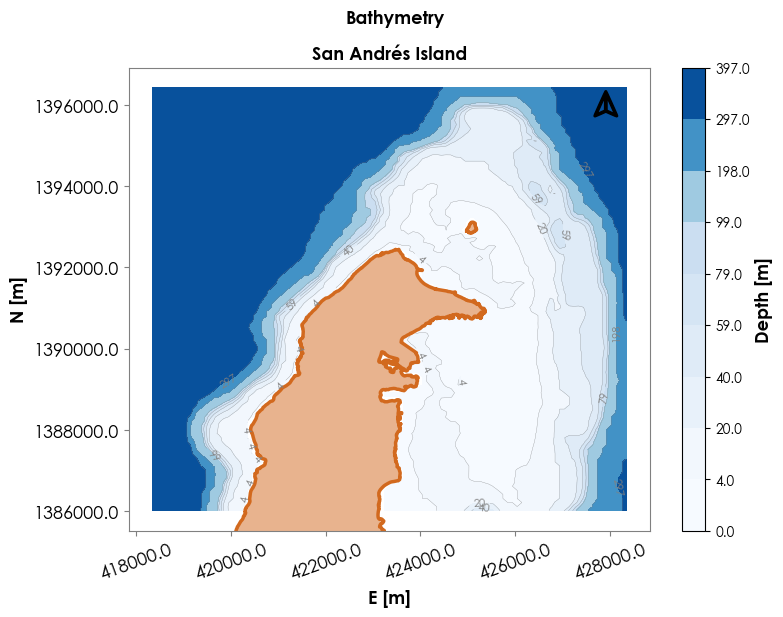

In [5]:
path = r'G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\BATIMETRIA\BAT_NORTE_RECTANGULAR_100m'
name_file_grid = 'BAT_SAI_NORTE.grd'
name_file_deep = 'BAT_SAI_NORTE.dep'
name_file_coast = 'COAST_LINE.mat'

num_lineas = 21
n_rows = 106 #83
n_cols = 102

df_lc = read_coast_line(path= path, name_file = name_file_coast)
X, Y, Z = read_grid_file_d3d(num_btw_lines = num_lineas, ncols = n_cols, 
                             nrows = n_rows, path = path, name_file_grid = name_file_grid, name_file_deep = name_file_deep)
df_bat_sai = df_project_grid_grid(n_cols = n_cols, n_rows = n_rows, X= X, Y = Y)
bat_figure(df_lc= df_lc,X= X, Y= Y, Z=Z[:-1,:-1], delta_lim= 500,delta = 450 ,size = (8, 6), active_puntos_obs = False)

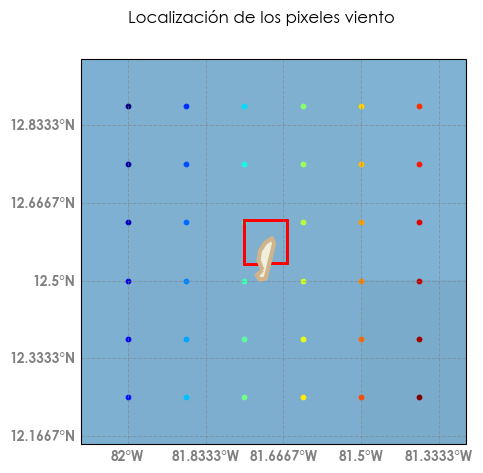

In [6]:
paths_wave = sorted(glob.glob(r"G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\BASES_DE_DATOS\CLIMATOLOGIA_ERA5\Data_Wave\*.nc"))
dic_wave = read_wave_era5(path = paths_wave[0])
plot_cells_data_base (variable = 'viento', lon = dic_wave['lon'] , lat = dic_wave['lat'], plot_dfbat = True, df_bat = df_bat_sai)

# MEAN VALUES

In [76]:
def mean_horly_pixel(lat:float, lon:float, paths:list):
    dic_data = {}
    for i, path in enumerate(paths):
        dic_pathi = read_wave_era5(path=path)
        lat_serie = dic_pathi['lat'] # Para iniciar de abajo hacia arriba
        lon_serie = dic_pathi['lon']
        ind_lat = np.where(lat_serie == lat )[0][0]
        ind_lon = np.where(lon_serie == lon )[0][0]
        df_pathi = pd.DataFrame({'time':dic_pathi['time'], 
                                'Hs':dic_pathi['Hs'][:,ind_lat, ind_lon], 'Tp':dic_pathi['Tp'][:,ind_lat, ind_lon], 
                                'Direc':dic_pathi['Direc'][:,ind_lat, ind_lon]})
        dic_data.update({i:df_pathi})
    
    df_pixel = pd.concat(dic_data, ignore_index=True)


    df_grouped = df_pixel.groupby([df_pixel['time'].dt.month, df_pixel['time'].dt.day, df_pixel['time'].dt.hour]).mean()
    df_grouped.index.set_names(['month', 'day', 'hour'], level=[0,1,2], inplace=True)
    df_grouped = df_grouped.reset_index()

    df_grouped['year'] = list(map(lambda x: int(x), np.ones(len(df_grouped))*2000))
    df_grouped['time'] = pd.to_datetime(df_grouped[['year','month', 'day','hour']], format=format).dt.strftime('%m-%d')
    df_grouped.set_index('time', inplace=True)
    df_grouped = df_grouped.iloc[:,:-1]

    return df_grouped


def func_dic_data_pixels (lat:np.array, lon:np.array, paths:list):
    dic_db = {}
    k = 0 
    for j in range(len(lat)):
        for i in range(len(lon)):
            df_pixel_i = mean_horly_pixel(lat = lat[j], lon= lon[i], paths= paths)
            dic_db.update({k:df_pixel_i})
            k = k+1
    return dic_db

def men_values_Hs (dic_pixels:dict, ind:int, variable:str):
    """_summary_

    Parameters
    ----------
    dic_pixels : dict
        Diccionario que contiene los data frame de cada pixel 
    ind : int
        indice del pixel a analizar 
    variable : str
        variable a evaluar ('Hs', 'Tp', 'Direc')

    Returns
    -------
    _pd.dataframe_
        Dataframe de los valores medios, y los valores medios agrupados por mes
    """
    df_mean = dic_pixels[ind][[variable]]
    df_mean_grouby = dic_pixels[ind].groupby('month').mean()[[variable]]
    return df_mean, df_mean_grouby

In [8]:
paths_wave = sorted(glob.glob(r"G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\BASES_DE_DATOS\CLIMATOLOGIA_ERA5\Data_Wave\*.nc"))
dic_wave = read_wave_era5(path = paths_wave[0])
lat = dic_wave['lat'] # Para iniciar de abajo hacia arriba
lon = dic_wave['lon']
lon_mesh, lat_mesh = np.meshgrid(lon, lat)
lon_re = np.reshape(lon_mesh, len(lat)*len(lon))
lat_re = np.reshape(lat_mesh, len(lat)*len(lon))

In [9]:
# Pixel al noreste
lat_sai, lon_sai = 12.63, 360-81.66
ind_ne = min_ind_reshape(value1 = lat_sai, vector1 = lat_re, value2 = lon_sai, vector2 = lon_re, delta = 0.125, view_coords = True)

#Pixel al noroeste
lat_sai, lon_sai = 12.63, 360-81.85
ind_nw = min_ind_reshape(value1 = lat_sai, vector1 = lat_re, value2 = lon_sai, vector2 = lon_re, delta = 0.125, view_coords = True)


# Pixel al sureste
lat_sai, lon_sai = 12.5, 360-81.66
ind_se = min_ind_reshape(value1 = lat_sai, vector1 = lat_re, value2 = lon_sai, vector2 = lon_re, delta = 0.125, view_coords = True)

#Pixel al suroeste
lat_sai, lon_sai = 12.5, 360-81.85
ind_sw = min_ind_reshape(value1 = lat_sai, vector1 = lat_re, value2 = lon_sai, vector2 = lon_re, delta = 0.125, view_coords = True)

************error**********************
Indices: 15
Valor 1: 12.625, Valor real 1: 12.63
Valor 2: 278.375, Valor real 2: 278.34000000000003
************error**********************
Indices: 14
Valor 1: 12.625, Valor real 1: 12.63
Valor 2: 278.25, Valor real 2: 278.15
************error**********************
Indices: 21
Valor 1: 12.5, Valor real 1: 12.5
Valor 2: 278.375, Valor real 2: 278.34000000000003
************error**********************
Indices: 20
Valor 1: 12.5, Valor real 1: 12.5
Valor 2: 278.25, Valor real 2: 278.15


In [136]:
months_names = calendar.month_abbr[1:]
months_names.append('Jan')
df_mean_ne, df_month_ne = men_values_Hs (dic_pixels = dic_pixels, ind = ind_ne, variable = 'Hs')
df_mean_ne.reset_index(inplace=True)
df_mean_nw, df_month_nw = men_values_Hs (dic_pixels = dic_pixels, ind = ind_nw, variable = 'Hs')
df_mean_nw.reset_index(inplace=True)

(-73.15, 1536.15)

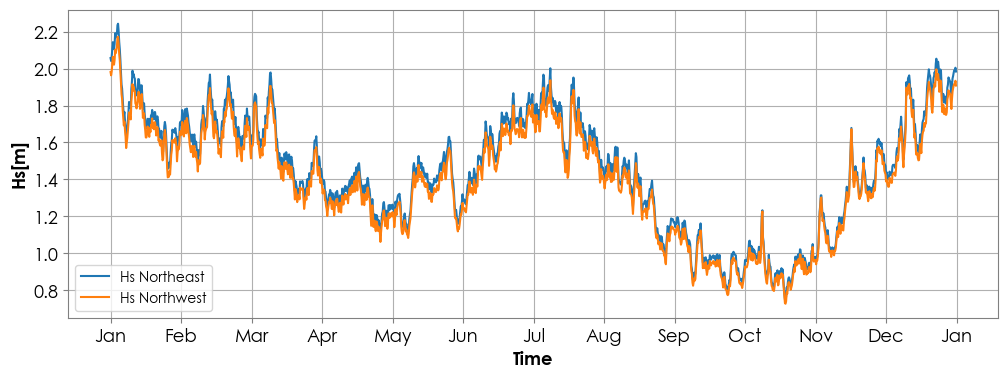

In [137]:
fig, ax = plt.subplots(figsize = (12,4))

ax_  = df_mean_ne.plot(ax = ax, x_compat = True)
ax_ = df_mean_nw.plot(ax = ax, x_compat = True)
fig_params(ax)
ax_.set_ylabel('Hs[m]', size = 13, fontweight = 'bold')
ax_.set_xlabel('Time', size = 13, fontweight = 'bold')
ax.legend(['Hs Northeast', 'Hs Northwest'])

freq_data = 6 #horas
len_data = len(df_mean_ne)
ticklabels = np.arange(0, len_data + 30.5/(freq_data/24) , 30.5/(freq_data/24))
ax.set_xticks(ticklabels)
# ax.set_xlim([ticklabels[0], ticklabels[-1]])
ax.set_xticklabels(months_names);
ax.tick_params(axis='x', labelrotation = 0)
ax.set_xlim()

Text(0.5, 1.0, 'Mean values of Hs')

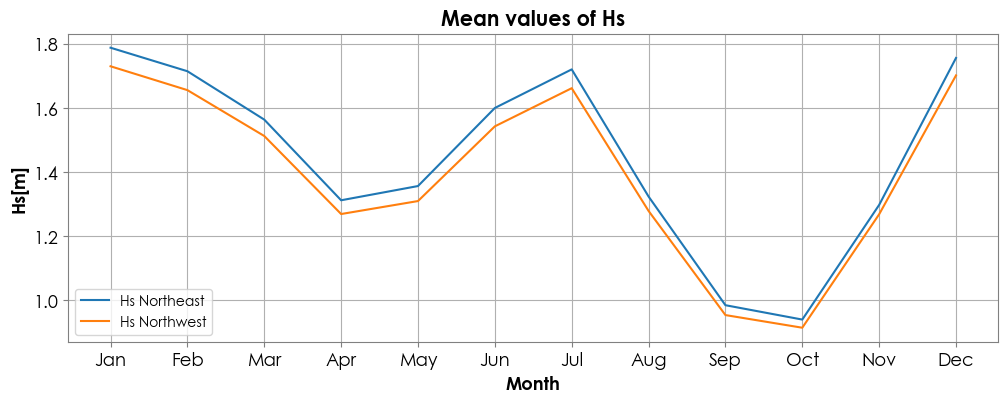

In [139]:
fig, ax = plt.subplots(figsize = (12,4))

ax_  = df_month_ne.plot(ax = ax)
ax_ = df_month_nw.plot(ax = ax)
fig_params(ax)
ax_.set_ylabel('Hs[m]', size = 13, fontweight = 'bold')
ax_.set_xlabel('Month', size = 13, fontweight = 'bold')
ax.legend(['Hs Northeast', 'Hs Northwest'])
ax.set_xticks(range(1,13))
ax.set_xticklabels(months_names[:-1]);
ax.tick_params(axis='x', labelrotation = 0)
ax.set_title('Mean values of Hs', size = 15, fontweight = 'bold')